In [25]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import utils.data_loader as data_loader
from models import MyMobileNetV2

In [2]:
print(tf.__version__)


2.11.0


In [23]:
data_dir = "../data/ali-ui"
train_ds,val_ds,lb =  data_loader.load_data(data_dir)
print("labels:",lb)

Found 5900 files belonging to 8 classes.
Using 4720 files for training.
Using 1180 files for validation.
labels: ['button', 'keyboard', 'navbar', 'searchbar', 'statusbar', 'stepper', 'switch', 'tabbar']


In [4]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.2901961 0.6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
148/148 [==============================] - 37s 246ms/step - loss: 0.6553 - accuracy: 0.7907 - val_loss: 0.2891 - val_accuracy: 0.9203
Epoch 2/10
148/148 [==============================] - 38s 256ms/step - loss: 0.2079 - accuracy: 0.9400 - val_loss: 0.2825 - val_accuracy: 0.9153
Epoch 3/10
148/148 [==============================] - 39s 263ms/step - loss: 0.1301 - accuracy: 0.9606 - val_loss: 0.2564 - val_accuracy: 0.9432
Epoch 4/10
148/148 [==============================] - 43s 291ms/step - loss: 0.0768 - accuracy: 0.9778 - val_loss: 0.3331 - val_accuracy: 0.9280
Epoch 5/10
148/148 [==============================] - 67s 450ms/step - loss: 0.0625 - accuracy: 0.9816 - val_loss: 0.3097 - val_accuracy: 0.9356
Epoch 6/10
148/148 [==============================] - 62s 422ms/step - loss: 0.0472 - accuracy: 0.9864 - val_loss: 0.3354 - val_accuracy: 0.9475
Epoch 7/10
148/148 [==============================] - 61s 412ms/step - loss: 0.0352 - accuracy: 0.9877 - val_loss: 0.3630 - val_ac

In [18]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss',  'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();



KeyError: 'prc'

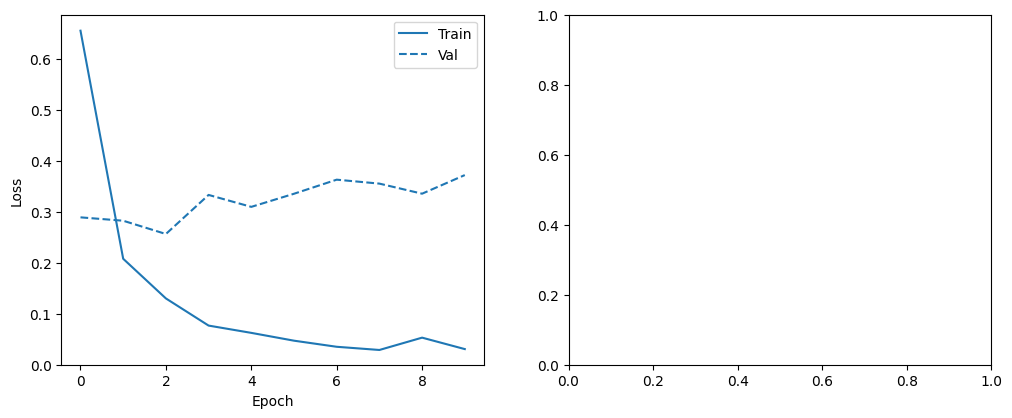

In [35]:
plot_metrics(history)


In [12]:
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet') 
base_model.trainable=False #冻结原网络的权重，不参与新数据集的训练。
model2 = tf.keras.models.Sequential([
  #像素值缩放到[-1,1]之间
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 之前几层的输出，作为大网的输入，大网的输出给到下一层
  base_model, #已经被冻结了，训练时它内部的所有层权重都不更新，只用来对输入图片提取特征。
  #对大网的输出（即提取的特征）做一次池化，同时
  tf.keras.layers.GlobalAveragePooling2D(), 
  #接上最终输出层
  tf.keras.layers.Dense(num_classes)
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=10
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
148/148 [==============================] - 35s 233ms/step - loss: 0.4805 - accuracy: 0.8542 - val_loss: 0.2295 - val_accuracy: 0.9297
Epoch 2/10
148/148 [==============================] - 35s 235ms/step - loss: 0.1934 - accuracy: 0.9460 - val_loss: 0.1787 - val_accuracy: 0.9432
Epoch 3/10
148/148 [==============================] - 35s 237ms/step - loss: 0.1472 - accuracy: 0.9581 - val_loss: 0.1577 - val_accuracy: 0.9483
Epoch 4/10
148/148 [==============================] - 36s 246ms/step - loss: 0.1209 - accuracy: 0.9663 - val_loss: 0.1458 - val_accuracy: 0.9517
Epoch 5/10
148/148 [==============================] - 45s 304ms/step - loss: 0.1031 - accuracy: 0.9710 - val_loss: 0.1380 - val_accuracy: 0.9542
Epoch 6/10
148/148 [==============================] - 64s 432ms/step - loss: 0.0901 - accuracy: 0.9761 - val_loss: 0.1327 - val_accuracy: 0.9576
Epoch 7/10
148/148 [==============================] - 63s 428ms/step - loss: 0.0798 - accuracy: 0.9794 - val_loss: 0.1289 - val_ac

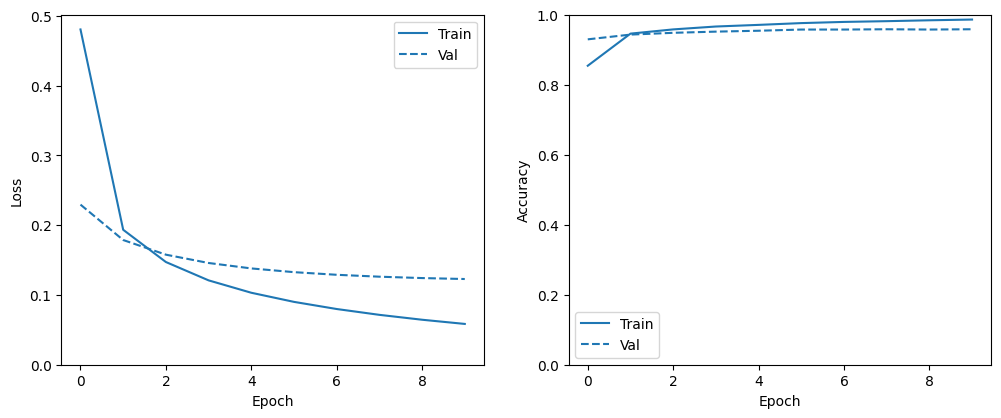

In [29]:
import importlib
importlib.reload(data_loader)
data_loader.plot_metrics(history2)